# <b style='color:orange'> Classifying with MMoCHi

**Author:** Daniel Caron

#### In this notebook, we walk through the general usage of the MMoCHi classifier to annotate celltypes in CITE-Seq data, integrated across multiple datasets and predict on a held out dataset.
***
### MMoCHi is a useful tool for:
    1. Identifying predefined cell types or states 
    2. Labelling cells by lineage when other sources of variation (such as activation state) dominate the variation in the dataset
    3. Distinguishing cell types that don't form discrete clusters in unsupervised analyses
    4. Integrating cell identification across samples — even when UMAP integration fails

## <b style='color:orange'> Import packages

In [1]:
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mmochi as mmc
mmc.log_to_file('data/mmochi_demo')

## <b style='color:orange'> Downloading and preprocessing the data 
Often, multiple samples, batches, or datasets may need to be annotated by a unified system. Here, we will demonstrate MMoCHi being used across multiple 10X Genomics sequencing runs (pbmc_10k_protein_v3 and 5k_pbmc_protein_v3) and being used to predict annotations on a held out dataset (pbmc_1k_protein_v3). First, we need to download the example datasets, perform normalization, and format them with the GEX data in the .X and the ADT data in the .obsm['protein_counts'].

In [2]:
files = ['pbmc_10k_protein_v3.h5','5k_pbmc_protein_v3.h5','pbmc_1k_protein_v3.h5']
cellranger_versions = ['3.0.0','3.0.2','3.0.0']
base_url =  f"http://cf.10xgenomics.com/samples/cell-exp/"
urls = [base_url + f"{v}/{i[:-3]}/{i[:-3]}_filtered_feature_bc_matrix.h5" for i,v in zip(files,cellranger_versions)]
adatas = mmc.utils.preprocess_adatas(['data/' + file for file in files],backup_urls = urls,log_CP_ADT=1000,log_CP_GEX=100000)
held_out_batch, held_out_file = adatas.pop(2),files.pop(2)
adata = anndata.concat(adatas,merge='first',keys=files,label='batch',index_unique='_')

 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning:Some cells have zero counts


<div class="alert alert-block alert-info">
<b>Training tip — data selection:</b> Carefully select which biological conditions, sequencing chemistries, alignment, and preprocessing to include in the training model for the classifier. Ideally, the training model should be representative of your total data!
</div>

We would first quickly run through scanpy's pipeline to create a UMAP for this dataset and calculate leiden clusters for reference later! For consistency, the X_UMAP and leiden clusters have been provided as .csv files to load in. 

In [3]:
# sc.pp.highly_variable_genes(adata)
# sc.pp.pca(adata)
# sc.external.pp.harmony_integrate(adata,adjusted_basis='X_pca',key='batch',verbose=False,max_iter_harmony=20)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.tl.leiden(adata)
# np.savetxt('data/Classifier_Demo_X_umap.txt',adata.obsm['X_umap'])
# adata.obs['leiden'].to_csv('data/Classifier_Demo_leiden.csv')
adata.obsm['X_umap'] = np.loadtxt('data/Classifier_Demo_X_umap.txt')
adata.obs['leiden'] = pd.read_csv('data/Classifier_Demo_leiden.csv').set_index('Unnamed: 0')['leiden'].astype(str)

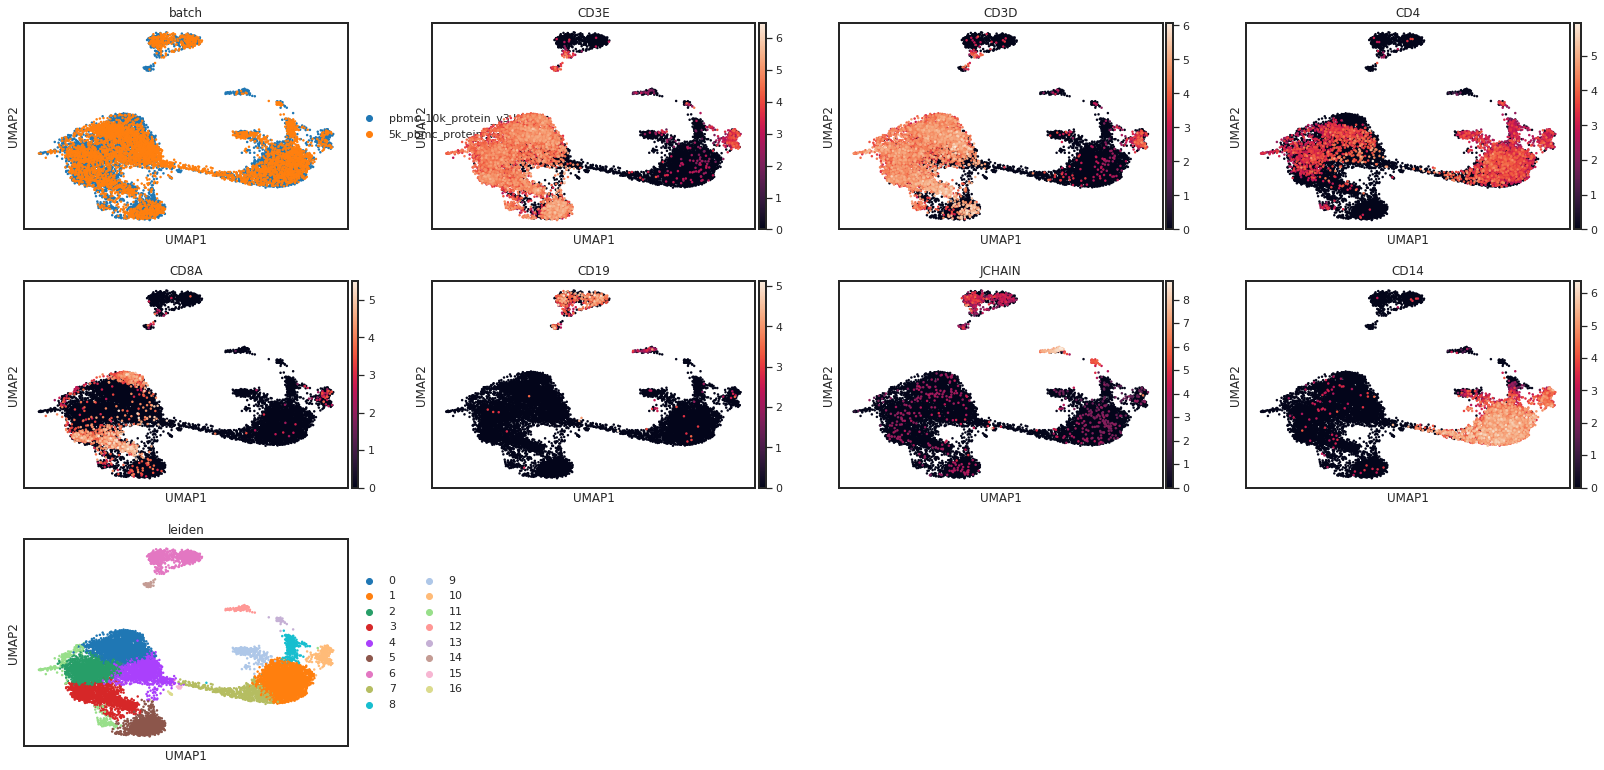

In [37]:
sc.pl.umap(adata,color=['batch','CD3E','CD3D','CD4','CD8A','CD19','JCHAIN','CD14','leiden'],s=25)

<div class="alert alert-block alert-warning">
<b>Check for junk or novel cell types</b> Here, you must inspect your clusters, and be sure that you will be able to (in the hierarchy) define all the cell types present, and that there are not significant amounts of junk or contaminants that do not belong to any of the classifications. Although there is some amount of removal of junk (via confidence thresholds), if large amounts of unexpected cells are labelled on ground truth, the classifier will assign high-confidence labels to them in potentially unexepected ways.
</div>


Here, we can identify a cluster of cells expression both CD3E/CD3D, and CD19 (cluster 14). These cells do not match our expectations for the blood immune component, and are potentially T/B cell doublets. We can remove them from classification by creating a new .obs column, and using a cutoff in the hierarchy.

In [5]:
adata.obs['to_remove'] = adata.obs.leiden.isin(['14']).astype(str)

## <b style='color:orange'> Normalizing ADTs - Landmark Registration
Because of variation in antibody staining conditions, CITE-Seq data requires careful integration! To integrate CITE-Seq data across datasets, we have deveoped a landmark registration function, which calculates a density function of marker expression, and then aligns the peaks across each batch.

<div class="alert alert-block alert-warning">
<b>Check carefully!</b> First, transform your data using arcsine or log normalization. Tune the transformation until you have separation of positive and negative populations on bimodal or trimodal markers. Then, select a CITE-Seq landmark registration package. Two options are the in-house implementation (mmc.landmark_register_adts()) or a more-advanced implementation in R (ADTnorm).
</div>

For classification, we should remove any isotype controls, or other ADTs whose expression we don't expect to vary with celltype.

In [6]:
adata.obsm['protein'].drop(['IgG2a_control','IgG2b_control','IgG1_control'],axis=1,inplace=True)

To make this landmark registration calculation reproducible if we want to project in data later, we fix the peak alignment for all markers to arbitrary values. Here I use 1 (for negative peaks) or 3 (for positive peaks). 

In [7]:
adata = mmc.landmark_register_adts(adata,batch_key='batch',single_peaks=['CD25'])

Running with batch batch


  0%|          | 0/2 [00:00<?, ?it/s]

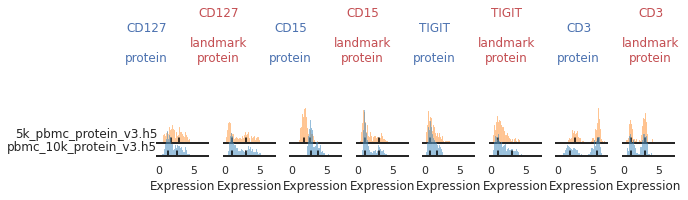

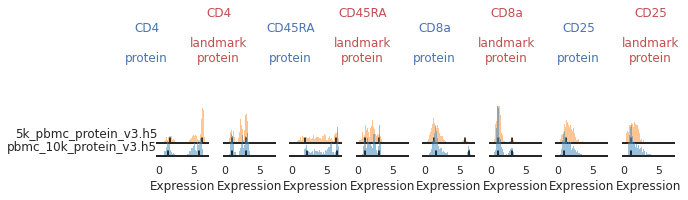

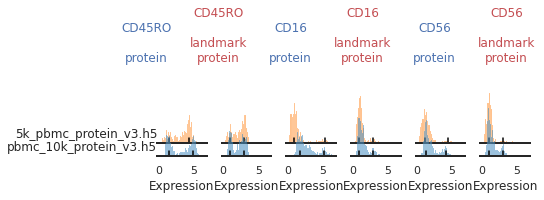

In [8]:
mmc.stacked_density_plots(adata,adata.obsm['protein'].columns[0:4],batch_key='batch', subsample = .1,height=1,aspect=1)
mmc.stacked_density_plots(adata,adata.obsm['protein'].columns[5:9],batch_key='batch', subsample = .1,height=1,aspect=1)
mmc.stacked_density_plots(adata,adata.obsm['protein'].columns[10:13],batch_key='batch', subsample = .1,height=1,aspect=1)

## <b style='color:orange'>Define the hierarchy

The Hierarchy class supports setting up the classification scheme and storing the classifiers. Here, we define a Hierarchy, with default settings for the training conditions. Then, we add classification levels to it. Some classification levels are defined as cutoffs, which just perform the thresholding defined, and provide the resulting cells as subsets below itself. The other classification levels will eventually become Random Forest classifiers. Subsets are assigned below each classification subset, and defining markers for each subset are specified.

In [9]:
h= mmc.Hierarchy(default_min_events=15,default_class_weight = 'balanced')

To add a classification level, you define a name, parent node (the root node in a Hierarchy object is "All"), and markers. Negative and positive markers for each population can be defined, as well as more complex boolean gating rules. Here, we add, a cutoff classification node for junk removal, to remove a leiden cluster we have previously identified as potential doublets. Then we add a gross immune compoenent classifier, to segregate lymphoid and myeloid cells.

In [10]:
h.add_classification('Junk_Removal','All', ['to_remove'], is_cutoff=True) 
h.add_subset('Junk','Junk_Removal',dict(other=['to_remove'],OTHER='True'))
h.add_subset('Immune cells','Junk_Removal',dict(other=['to_remove'],OTHER='False'))

In [11]:
h.add_classification('Gross','Immune cells', ['CD14','CD33','MARCO','MERTK','CD3','CD19','CD127','JCHAIN']) 
h.add_subset('Lymphocyte','Gross',dict(neg = ['CD14','CD33','MARCO','MERTK'],any_of=['CD3','CD19','CD127','JCHAIN'],n=1))
h.add_subset('Myelocyte','Gross',dict(any_of = ['CD14','CD33','MARCO','MERTK'],n=1, neg=['CD3','CD19','CD127','JCHAIN']))

Distinguishing these populations in a hierarchy helps prevent the algorithm from confusing cell types that are only very distantly related.

In [12]:
h.add_classification('Lymphoid','Lymphocyte',['CD3','CD19','CD56','CD127','JCHAIN'])           
h.add_subset('T cell','Lymphoid',dict(pos=['CD3','CD127'],neg=['CD19','JCHAIN']))
h.add_subset('B cell','Lymphoid',dict(any_of=['CD19'], neg=['CD3','CD127','JCHAIN']))
h.add_subset('Plasma cell','Lymphoid',dict(any_of=['JCHAIN'], neg=['CD3','CD127']))
h.add_subset('NK/ILC','Lymphoid',dict(neg=['CD19','JCHAIN','CD3'], any_of=['CD127','CD56']))

<div class="alert alert-block alert-info">
<b>Training tip — hierarchy design:</b> Here, the hierarchy is setup to reflect known shared precursors and cell lineages, but lineage-based hierarchies aren't always the most effective! When adding new cells to the hierarchy, consider what other cell types share the most transcriptomic and phenotypic identity. If two or more cell types share more features across an axis than they differ, it may be helpful to group them together and separate them lower in the hierarchy!
</div>

In [13]:
h.add_classification('NK/ILC Subsets','NK/ILC',['CD127','EOMES'])# NCR3
h.add_subset('NK','NK/ILC Subsets',['neg','pos']) 
h.add_subset('ILC','NK/ILC Subsets',['pos','neg'])

Each subset's marker expression can be defined either by lists of "pos", "neg", or "any", where markers are ordered the same as the classification level above it, or as a dictionary, which is interpreted by the `mmc.hierarchy.gt_defs` function, allowing for complex gating strategies. See the docstring for more details on possible options.

In [14]:
h.add_classification('CD4_CD8','T cell',['CD4','CD8a','CD4_gex','CD8A'],clf_kwargs=dict(max_features=.25))
h.add_subset('CD4 T cell','CD4_CD8',['pos','neg','any','neg'])
h.add_subset('CD8 T cell','CD4_CD8',['neg','pos','neg','pos'])

<div class="alert alert-block alert-warning">
<b>Training tip — clf_kwargs:</b> To optimize cell classification, sometimes the default random forest needs adjustment. For example, here CD4 and CD8 T cells are reliably distinguishable by only a few markers. The hierarchy supports this by allowing each classification level to pass their own kwargs to the sklearn RandomForestClassifier. Here, we increase max_features to decrease the randomness of the forest. Read more about kwarg options <b><u><a here="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">here</a></b></u>!
</div>

Now that the hierachy has been defined, we can take a look at it! These helper functions are great for visualizing the classification levels (ovals) and subset defintiions (rectangles).

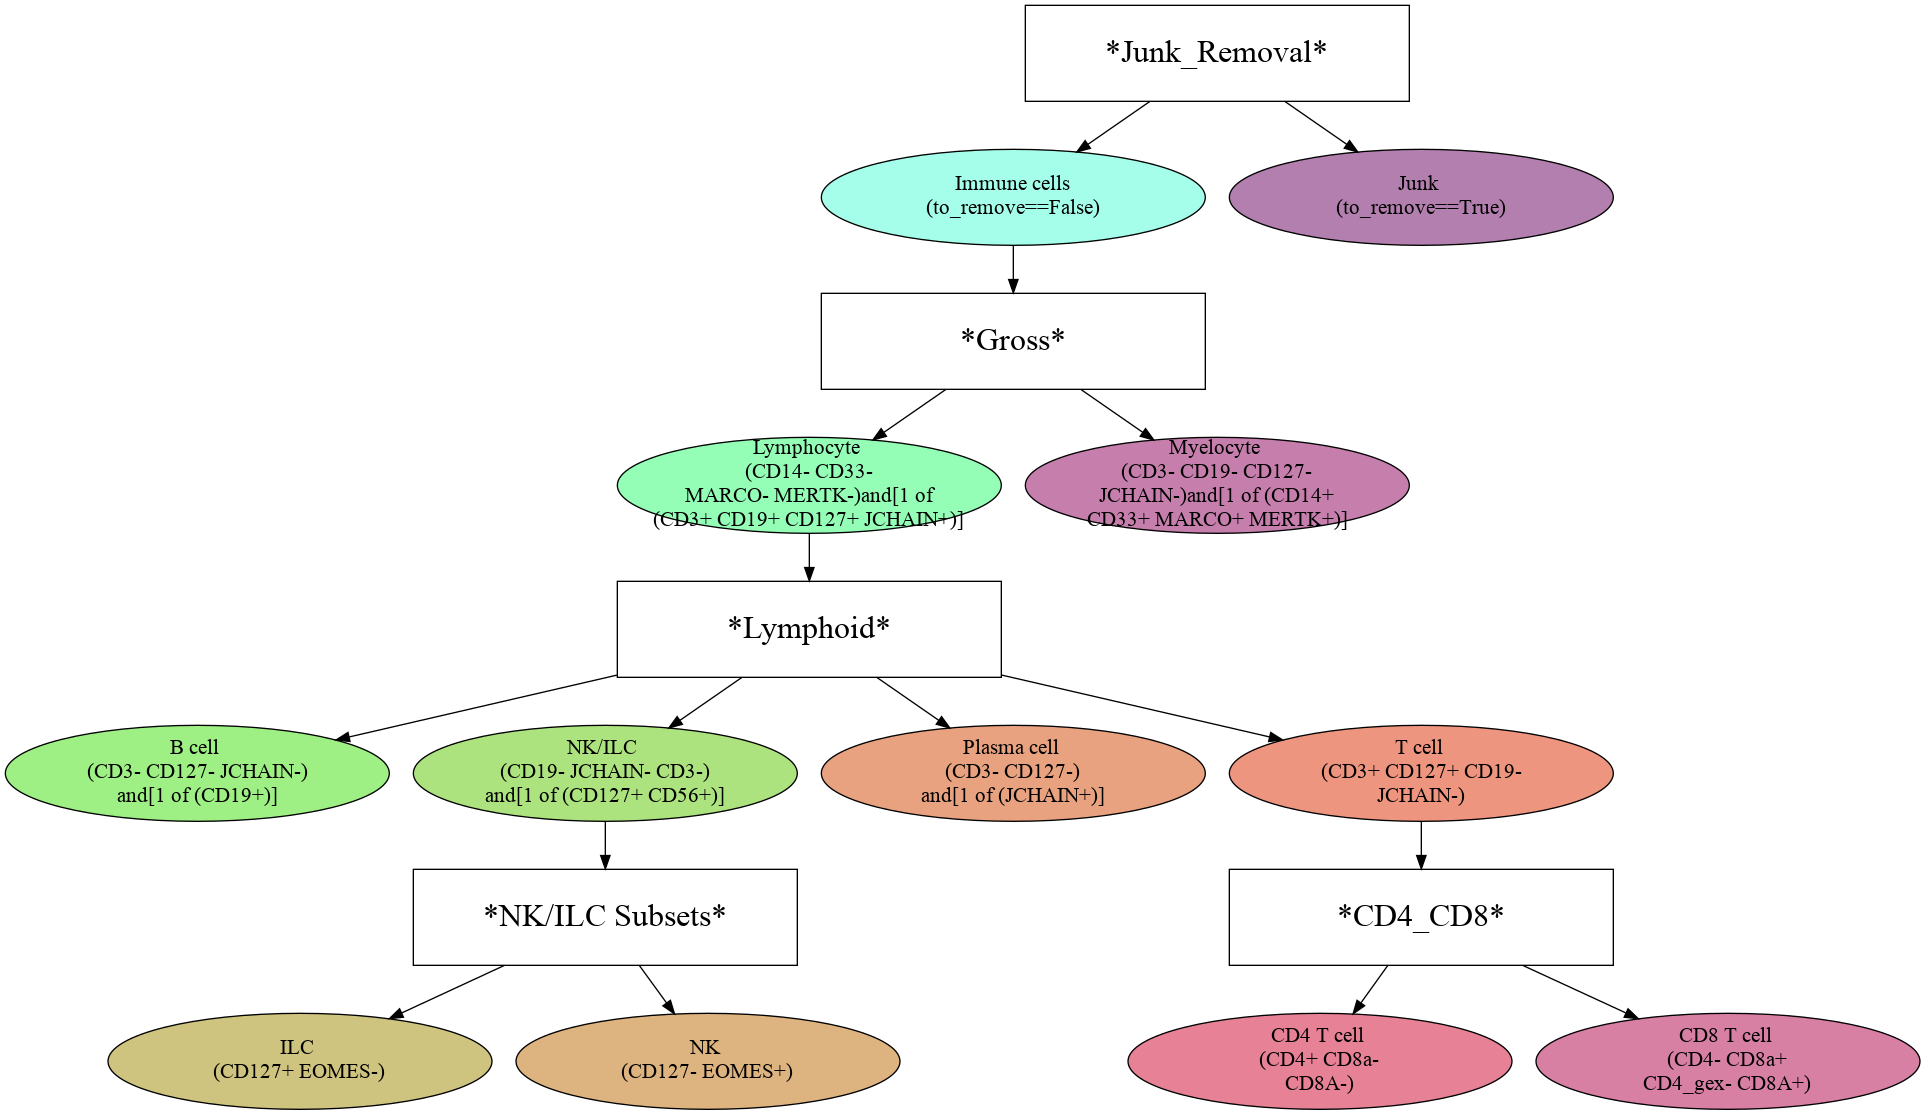

In [15]:
h.color_dict(True,rot=1,hue=3, mode='DEPTH')
h.display(True)

## <b style='color:orange'> Run thresholding
In order to define ground-truth data for training the classifier, we must identify positive and negative populations for each marker defined in the hierarchy. The Hierarchy object stores thresholds for each marker, which can be saved and loaded from a .csv for convenience.    

In [16]:
h.reset_thresholds()
h.load_thresholds('data/integrated_thresholds.csv')

Loaded thresholds.


Thresholding can be performed on any transformation of the ADTs that produces clear positive and negative populations. Although MMoCHi will attempt to predict thresholds from a gaussian mixed model, these predictions are far from perfect. Thresholds must be carefully defined for each marker used in the hierarchy for each sample. Using the "fancy" keyword in any mode name activates iPython widgets!

In [17]:
h.run_all_thresholds(adata,data_key='landmark_protein',batch_key='batch',mode='fancy fill in')

Running with batch batch
to_remove not found in adata, skipping thresholding.
to_remove not found in adata, skipping thresholding.


Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

<div class="alert alert-block alert-info">
    <b>How do I choose the best thresholds?</b> Carefully gating your populations can greatly improve the training data your classifier recieves, and therefore your cell calls, but figuring out how gates need to be adjusted can be tricky! On cleanly bimodal markers, you want to include cells that are clearly in the positive and negative distributions, leaving events with middling expression of the marker undefined. Be careful not to leave too many cells undefined though! Limiting your calls to only the most extreme positive and negative cells may inadvertently train the classifier on only a subset of the cell lineage, or on only the highest quality of data, neither of which would produce effective calls! MMoCHi has other tools to assist with threshold selection for more complex markers, which are either not bimodal or on cell subsets that are defined by combinatorial expression. Tutorials in progress will cover this in more detail!
</div>

Be sure to save your thresholds to a .csv, as these will be useful as you iteratively train the classifier to fine tune population identification! When overwriting a file, this special save function saves non-destructively, replacing only the markers that you define each run — so if you remove a marker temporarily from the hierarchy, those carefully defined thresholds will not be lost!

In [18]:
h.save_thresholds('data/integrated_thresholds.csv')

Saving non-destructively...


## <b style='color:orange'> Train and run the classifier
It's finally time to train the classifier. The classify function works its way down the hiarachy, identifying ground truth populations, training a RandomForestClassifier, and storing that classifier back in the hierarchy. Then, it uses that classifier to predict cell subsets at that level, before moving down to classifiers for those subsets. Future runs of the classify function with `retrain=False` will be able to use those classifier objects to predict celltypes without retraining.

In [19]:
adata.obs.batch.value_counts()

pbmc_10k_protein_v3.h5    7865
5k_pbmc_protein_v3.h5     5247
Name: batch, dtype: int64

In [20]:
adata,hierarchy = mmc.classify(adata, h.copy(), 'lin', 'landmark_protein', batch_key='batch',retrain = True,weight_integration=True)

Setting up...
Using .X and landmark_protein


Removing 18757 features lacking expression in a minimum of 25 events...
Resorting to enforce sorted order of features by name


Set up complete.
Using 14795 features


Running with batch batch
Using weights of: [0.4001677852348993, 0.5998322147651006] for random forest n_estimators


Data subsetted on All in All
Running ground truths for Junk_Removal...


Running ground truths in 5k_pbmc_protein_v3.h5
Running ground truths in pbmc_10k_protein_v3.h5


Performing cutoff for Junk_Removal...
Merging data into adata.obsm['lin']
Predicted:
Immune cells    13067
Junk               45
Name: Junk_Removal_class, dtype: int64
Data subsetted on Immune cells in Junk_Removal
Running ground truths for Gross...


Running ground truths in 5k_pbmc_protein_v3.h5
Running ground truths in pbmc_10k_protein_v3.h5


Preparing training data for Gross...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'Lymphocyte': 1.114847406246444, 'Myelocyte': 2.2621183026690743}


Initializing classifier for Gross...


Training 41 new estimators using 5k_pbmc_protein_v3.h5...


Choosing training data...


3353 real cells in training set...


Resampling...


Found: 12 noise and 7 in danger of 3353 events.


Training with 5080 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.3s finished
Training 60 new estimators using pbmc_10k_protein_v3.h5...


Choosing training data...


4365 real cells in training set...


Resampling...


Found: 207 noise and 0 in danger of 4365 events.


Training with 6962 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Runing calibration on random forest


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Predicting for Gross...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s


Merging data into adata.obsm['lin']
Predicted:
Lymphocyte    9261
Myelocyte     3806
Name: Gross_class, dtype: int64


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.5s finished


Data subsetted on Lymphocyte in Gross
Running ground truths for Lymphoid...


Running ground truths in 5k_pbmc_protein_v3.h5
Running ground truths in pbmc_10k_protein_v3.h5


Preparing training data for Lymphoid...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'B cell': 3.153853832578721, 'NK/ILC': 2.40742756322554, 'Plasma cell': 9.993833715284998, 'T cell': 1.181047321647579}


Initializing classifier for Lymphoid...


Training 41 new estimators using 5k_pbmc_protein_v3.h5...


Choosing training data...


2222 real cells in training set...


Resampling...


Found: 13 noise and 11 in danger of 2222 events.


Training with 6832 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.6s finished
Training 60 new estimators using pbmc_10k_protein_v3.h5...


Choosing training data...


3615 real cells in training set...


Resampling...


Found: 95 noise and 8 in danger of 3615 events.


Training with 9616 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s


Merging data into adata.obsm['lin']
Runing calibration on random forest


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.2s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Predicting for Lymphoid...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Predicted:
T cell         6802
NK/ILC         1436
B cell          897
Plasma cell     126
Name: Lymphoid_class, dtype: int64
Data subsetted on NK/ILC in Lymphoid
Running ground truths for NK/ILC Subsets...


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.3s finished
Running ground truths in 5k_pbmc_protein_v3.h5
Running ground truths in pbmc_10k_protein_v3.h5


Preparing training data for NK/ILC Subsets...


Checking subsets for minimum events...
Spiking in 5 of ILC in 5k_pbmc_protein_v3.h5 to reach 15 events
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'ILC': 2.750494026771254, 'NK': 1.0734607029578223}


Initializing classifier for NK/ILC Subsets...


Training 41 new estimators using 5k_pbmc_protein_v3.h5...


Choosing training data...


80 real cells in training set...


Resampling...


Found: 5 noise and 2 in danger of 80 events.


Training with 142 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.1s finished
Training 60 new estimators using pbmc_10k_protein_v3.h5...


Choosing training data...


196 real cells in training set...


Resampling...


Found: 4 noise and 4 in danger of 196 events.


Training with 348 events after oversample resampling...
Merging data into adata.obsm['lin']
Runing calibration on random forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic


Predicting for NK/ILC Subsets...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished


Merging data into adata.obsm['lin']
Predicted:
NK     1218
ILC     218
Name: NK/ILC Subsets_class, dtype: int64
Data subsetted on T cell in Lymphoid
Running ground truths for CD4_CD8...


Running ground truths in 5k_pbmc_protein_v3.h5
Running ground truths in pbmc_10k_protein_v3.h5


Preparing training data for CD4_CD8...


Checking subsets for minimum events...
{'max_features': 0.25, 'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'CD4 T cell': 1.150835602249348, 'CD8 T cell': 2.0204948583560847}


Initializing classifier for CD4_CD8...


Training 41 new estimators using 5k_pbmc_protein_v3.h5...


Choosing training data...


2172 real cells in training set...


Resampling...


Found: 69 noise and 78 in danger of 2172 events.


Training with 3868 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.9s finished
Training 60 new estimators using pbmc_10k_protein_v3.h5...


Choosing training data...


2814 real cells in training set...


Resampling...


Found: 33 noise and 48 in danger of 2814 events.


Training with 4052 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s


Merging data into adata.obsm['lin']
Runing calibration on random forest


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic


Predicting for CD4_CD8...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Predicted:
CD4 T cell    4902
CD8 T cell    1900
Name: CD4_CD8_class, dtype: int64


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.2s finished


Classification information for each cell is stored by default in a dataframe in the `.obsm['lin']`. This includes information for each classification level on whether a cell was identified by the ground truth thresholding, whether it was set aside as training data, how many times it was represented in the training data (oversampling and the in_danger_noise checker cause cells can both pull training cells randomly with replacement to generate balanced training datasets), its probability identification, and its ultimate classification.

In [21]:
adata.obsm['lin']

,All_class,Junk_Removal_gt,Junk_Removal_class,Gross_gt,Gross_trains,Gross_tcounts,Gross_train,Gross_proba,Gross_class,Lymphoid_gt,...,NK/ILC Subsets_tcounts,NK/ILC Subsets_train,NK/ILC Subsets_proba,NK/ILC Subsets_class,CD4_CD8_gt,CD4_CD8_trains,CD4_CD8_tcounts,CD4_CD8_train,CD4_CD8_proba,CD4_CD8_class
AAACCCAAGATTGTGA-1_pbmc_10k_protein_v3.h5,All,Immune cells,Immune cells,?,False,0.0,False,1.000000,Myelocyte,NaN,...,NaN,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN
AAACCCACATCGGTTA-1_pbmc_10k_protein_v3.h5,All,Immune cells,Immune cells,?,False,0.0,False,1.000000,Myelocyte,NaN,...,NaN,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN
AAACCCAGTACCGCGT-1_pbmc_10k_protein_v3.h5,All,Immune cells,Immune cells,Myelocyte,False,0.0,False,1.000000,Myelocyte,NaN,...,NaN,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN
AAACCCAGTATCGAAA-1_pbmc_10k_protein_v3.h5,All,Immune cells,Immune cells,?,False,0.0,False,0.965517,Lymphocyte,NK/ILC,...,0.0,False,1.0,NK,NaN,True,NaN,True,NaN,NaN
AAACCCAGTCGTCATA-1_pbmc_10k_protein_v3.h5,All,Immune cells,Immune cells,?,False,0.0,False,0.965517,Lymphocyte,NK/ILC,...,1.0,True,1.0,NK,NaN,True,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGCACAAG-1_5k_pbmc_protein_v3.h5,All,Immune cells,Immune cells,Lymphocyte,False,0.0,False,1.000000,Lymphocyte,?,...,NaN,True,NaN,NaN,CD8 T cell,True,4.0,True,1.0,CD8 T cell
TTTGTTGCAGTCTTCC-1_5k_pbmc_protein_v3.h5,All,Immune cells,Immune cells,Lymphocyte,True,1.0,True,1.000000,Lymphocyte,T cell,...,NaN,True,NaN,NaN,CD4 T cell,False,0.0,False,1.0,CD4 T cell
TTTGTTGCATGGCCCA-1_5k_pbmc_protein_v3.h5,All,Immune cells,Immune cells,?,False,0.0,False,1.000000,Lymphocyte,T cell,...,NaN,True,NaN,NaN,CD8 T cell,False,0.0,False,1.0,CD8 T cell
TTTGTTGCATTGCCGG-1_5k_pbmc_protein_v3.h5,All,Immune cells,Immune cells,Myelocyte,True,2.0,True,1.000000,Myelocyte,NaN,...,NaN,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN


Immediately after classification, you may be interested in identifying cells by their lowest resolution annotation. This function will add columns to the `.obs` for the classification and confidence level of each call. Note, these confidence values reflect the percent of the forest in agreement with the cell call, and are not linearlly related to the accurate of the cell call (more on that later)

In [22]:
adata = mmc.terminal_names(adata)

<div class="alert alert-block alert-info">
<b>Tip — Cleaning classifications:</b> If you expect clustering to perform well at separating cell types, with only a few mixed clusters, try majority voting! Pass a <code>voting_reference</code> column in the <code>.obs</code>, along with a <code>majority_min</code> to define the minimum majority for a cluster to be called a single celltype </div>

## <b style='color:orange'> Evaluate the classifier's performance
Once you've trained your first classifier, you might be wondering how accurate those classifications are! There will be a much longer tutorial on classifier evaluation and problem identification, but here are some quick ways to get started!
#### Do classifications align with expected marker expression?
First, we can inspect the classifications using the UMAP calculated earlier, and known marker genes! The classification calls should algin closely to the expression patterns of the known marker genes. Further inspection may include analyzing marker distribution within each population to identify any outliers.

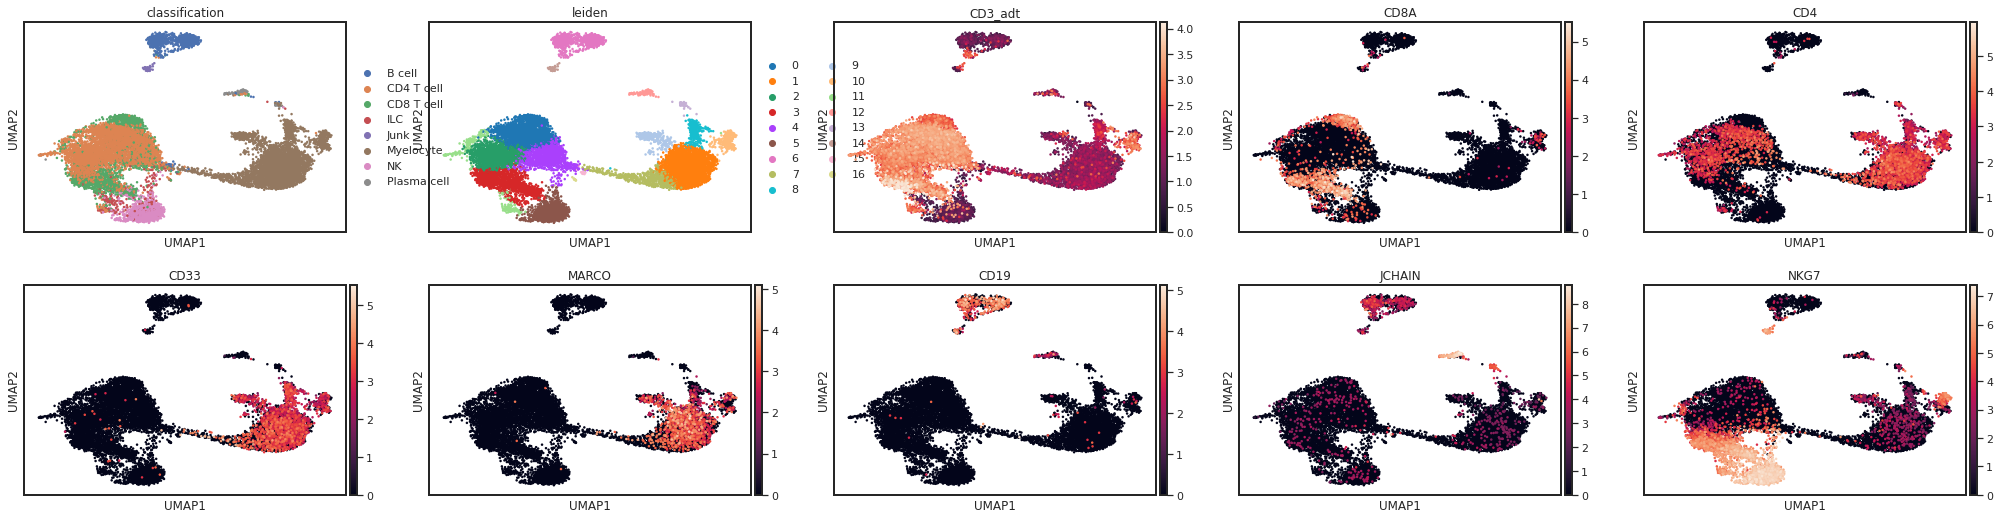

In [38]:
adata.obs[['CD3_adt','CD4_adt','CD8_adt','CD14_adt']] = adata.obsm['landmark_protein'][['CD3','CD4','CD8a','CD14']]
sc.pl.umap(adata,color=['classification','leiden','CD3_adt','CD8A','CD4','CD33','MARCO','CD19','JCHAIN','NKG7'],ncols=5,s=25)

#### How consistent is the classifier at predicting the ground truth data?
Confusion matricies score the training on held_out data! This is a very useful internal control (assuming your ground truth populations are pure) to tell you how well the random forests are performing! Cells on the diagonal are correctly called, and others are miscalled.

<i>Note that there're currently issues with batch spike-ins of rare classes, in that there is not a consistent 20% hold out maintained. Thus, exercise caution when interpreting these plots when large populations are used for spike ins. Also, if any column or row sums to 0, F1, Precision, and Recall values are invalid.</i>

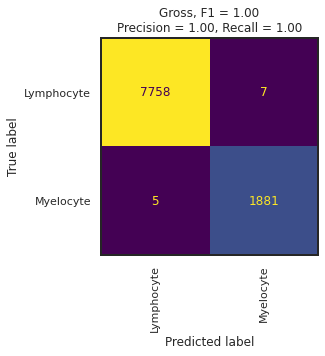

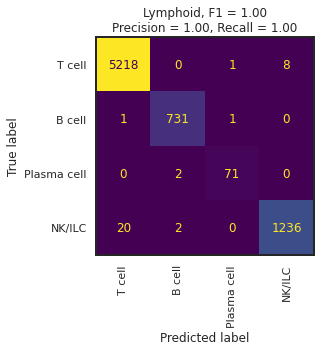

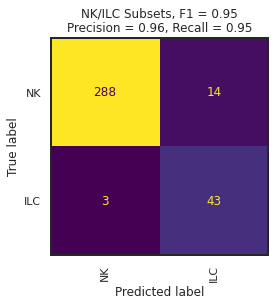

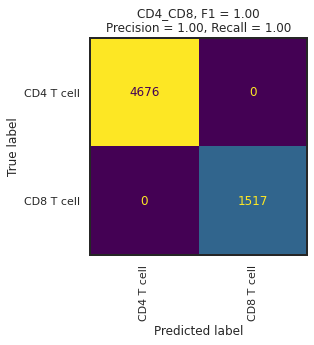

In [24]:
mmc.plot_confusion(adata,'All',hierarchy,show=True,hold_out_only=False)#, save='Confusion_plots.pdf')

## <b style='color:orange'> Save and load your model!

The hierachy object can be saved for future classification as a .hierarchy file!

In [25]:
hierarchy.save('data/IntegratedClassifier')

To load the hierarchy, just specify the name in the object creation

In [26]:
hierarchy = mmc.Hierarchy(load='data/IntegratedClassifier')

Loading classifier from data/IntegratedClassifier...


Loaded data/IntegratedClassifier.hierarchy


## <b style='color:orange'> Run the classifier on another donor
Running the classifier on another donor requires the features line up exactly. Ideally, this means the feature matricies using the same or very similar alignment conditions, and both training and predicted datasets are subjected to similar preprocessing. This is all true for our held out dataset!
First, we use the same landmark registration function with the same settings as performed on our training dataset.

In [27]:
held_out_batch.obs['batch'] = 'batch_1'

In [28]:
held_out_batch = mmc.landmark_register_adts(held_out_batch,batch_key='batch',single_peaks=['CD25'])

Running with batch batch


  0%|          | 0/1 [00:00<?, ?it/s]

Since we have included a cutoff above, we will need to provide the same data here (in this case, a .obs column) for the cutoff to be performed again. Let's imagine in this case, there are no CD3E/CD19 double-positive events that we are concerned about

In [29]:
held_out_batch.obs['to_remove'] = 'False'

Then, predicting on the data is as simple as running the classify function, and collecting the terminal names in the `.obs`. Note that this function runs much quicker than training a large dataset.

In [30]:
held_out_batch,_ = mmc.classify(held_out_batch,hierarchy,'lin',data_key='landmark_protein',reduce_features_min_cells=0)
held_out_batch = mmc.terminal_names(held_out_batch)

Setting up...
Using .X and landmark_protein


No min_cells feature reduction...
Resorting to enforce sorted order of features by name


Set up complete.
Using 33555 features


Using weights of: [1.0] for random forest n_estimators


Data subsetted on All in All
Running ground truths for Junk_Removal...
Performing cutoff for Junk_Removal...
Merging data into adata.obsm['lin']
Predicted:
Immune cells    713
Name: Junk_Removal_class, dtype: int64
Data subsetted on Immune cells in Junk_Removal
Predicting for Gross...


Limiting features using listlike, make sure you include modality information...


Merging data into adata.obsm['lin']
Predicted:
Lymphocyte    450
Myelocyte     263
Name: Gross_class, dtype: int64
Data subsetted on Lymphocyte in Gross
Predicting for Lymphoid...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
Limiting features using listlike, make sure you include modality information...


Merging data into adata.obsm['lin']
Predicted:
T cell         335
B cell          79
NK/ILC          33
Plasma cell      3
Name: Lymphoid_class, dtype: int64
Data subsetted on NK/ILC in Lymphoid
Predicting for NK/ILC Subsets...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
Limiting features using listlike, make sure you include modality information...


Merging data into adata.obsm['lin']
Predicted:
ILC    17
NK     16
Name: NK/ILC Subsets_class, dtype: int64
Data subsetted on T cell in Lymphoid
Predicting for CD4_CD8...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
Limiting features using listlike, make sure you include modality information...


Merging data into adata.obsm['lin']
Predicted:
CD4 T cell    215
CD8 T cell    120
Name: CD4_CD8_class, dtype: int64


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished


Lastly, to verify the classifier performed well, we can check whether the classifications align to known marker genes and proteins for these populations.

In [31]:
sc.pp.highly_variable_genes(held_out_batch)
sc.pp.pca(held_out_batch)
sc.pp.neighbors(held_out_batch)
sc.tl.umap(held_out_batch)
sc.tl.leiden(held_out_batch)

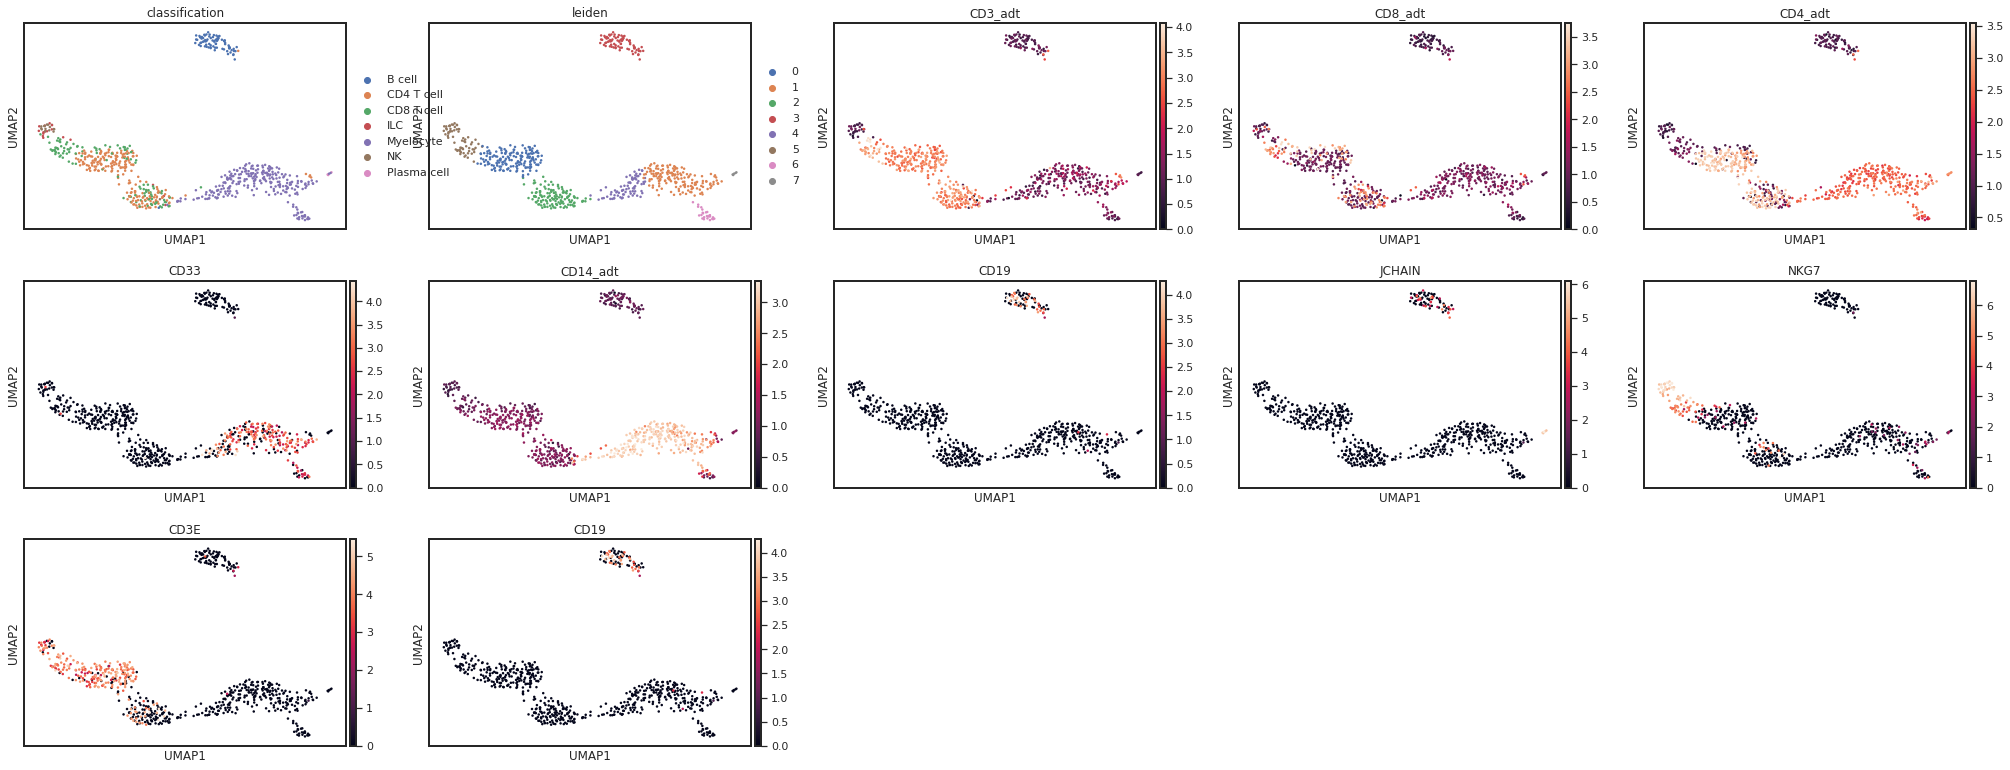

In [36]:
held_out_batch.obs[['CD3_adt','CD4_adt','CD8_adt','CD14_adt']] = held_out_batch.obsm['landmark_protein'][['CD3','CD4','CD8a','CD14']]
sc.pl.umap(held_out_batch,color=['classification','leiden','CD3_adt','CD8_adt','CD4_adt','CD33','CD14_adt','CD19','JCHAIN','NKG7','CD3E','CD19'],ncols=5,s=25)

<div class="alert alert-block alert-success">
<b>Congratulations!</b> You've completed your first tutorial with MMoCHi!<br>
</div>